<a href="https://colab.research.google.com/github/dornercr/INFO371/blob/main/INFO371_week5_featureengineering_ensemblelearning_crossvalidation_sports.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
# INFO 371: Week 5 Topics - Feature Engineering, Ensemble Learning, Cross Validation (Fixed)

# 0. Import Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GridSearchCV, LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns



In [31]:
# 1. Generate a Realistic Dataset
np.random.seed(42)
teams = ['Lions', 'Tigers', 'Bears', 'Wolves', 'Eagles', 'Sharks']
data = []

for date in pd.date_range(start='2023-01-01', periods=300):
    home_team = np.random.choice(teams)
    visitor_team = np.random.choice([t for t in teams if t != home_team])
    home_score = np.random.poisson(80)
    visitor_score = np.random.poisson(78)
    data.append([date, home_team, visitor_team, home_score, visitor_score])

games = pd.DataFrame(data, columns=['Date', 'HomeTeam', 'VisitorTeam', 'HomeScore', 'VisitorScore'])
games.sort_values('Date', inplace=True)


In [32]:
# 2. Create Target Label: Home Win or Not
games['HomeWin'] = (games['HomeScore'] > games['VisitorScore']).astype(int)

In [33]:
# 3. Feature Engineering
won_last = {team: 0 for team in teams}
home_last_won = []
visitor_last_won = []

for _, row in games.iterrows():
    home_last_won.append(won_last[row['HomeTeam']])
    visitor_last_won.append(won_last[row['VisitorTeam']])

    if row['HomeScore'] > row['VisitorScore']:
        won_last[row['HomeTeam']] = 1
        won_last[row['VisitorTeam']] = 0
    else:
        won_last[row['HomeTeam']] = 0
        won_last[row['VisitorTeam']] = 1

games['HomeLastWon'] = home_last_won
games['VisitorLastWon'] = visitor_last_won

In [34]:
# 4. Add Features
games['HomeAvgScore'] = games.groupby('HomeTeam')['HomeScore'].transform(lambda x: x.rolling(5, min_periods=1).mean())
games['VisitorAvgScore'] = games.groupby('VisitorTeam')['VisitorScore'].transform(lambda x: x.rolling(5, min_periods=1).mean())
games['ScoreDiff'] = games['HomeAvgScore'] - games['VisitorAvgScore']

In [35]:
# 5. Feature and Label Selection
features = games[['HomeLastWon', 'VisitorLastWon', 'ScoreDiff']]
labels = games['HomeWin']


In [37]:
# 6. Class Weights to Balance
class_weights = dict(zip(np.unique(labels), compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)))


In [39]:
# 7. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [40]:
# 8. Models
# KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
knn_preds = knn.predict(X_test)
print("KNN Accuracy:", accuracy_score(y_test, knn_preds))

# Random Forest (Improved with class_weight)
rf = RandomForestClassifier(n_estimators=100, max_features=2, random_state=42, class_weight=class_weights)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))

KNN Accuracy: 0.6666666666666666
Random Forest Accuracy: 0.6166666666666667


In [41]:
# 9. Bias-Variance Tradeoff Comment
print("""
- KNN with small k may have high variance (overfitting).
- Random Forest reduces variance with many trees (averaging effect).
- Goal: minimize both bias (wrong assumptions) and variance (too sensitive).
""")


- KNN with small k may have high variance (overfitting).
- Random Forest reduces variance with many trees (averaging effect).
- Goal: minimize both bias (wrong assumptions) and variance (too sensitive).



In [42]:
# 10. Cross-Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
rf_cv_scores = cross_val_score(rf, features, labels, cv=kfold)
print("Random Forest KFold CV Accuracy:", np.mean(rf_cv_scores))

loo = LeaveOneOut()
small_features = features.sample(50, random_state=42)
small_labels = labels.loc[small_features.index]
loo_scores = cross_val_score(knn, small_features, small_labels, cv=loo)
print("KNN LOO CV Accuracy (subset):", np.mean(loo_scores))

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
stratified_scores = cross_val_score(rf, features, labels, cv=skfold)
print("Random Forest StratifiedKFold CV Accuracy:", np.mean(stratified_scores))

Random Forest KFold CV Accuracy: 0.5733333333333334
KNN LOO CV Accuracy (subset): 0.52
Random Forest StratifiedKFold CV Accuracy: 0.6133333333333334


In [43]:
# 11. Grid Search for Random Forest
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_features': [1, 2]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42, class_weight=class_weights), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Parameters from Grid Search:", grid_search.best_params_)
final_model = grid_search.best_estimator_
final_preds = final_model.predict(X_test)
print("Final Model Accuracy after Grid Search:", accuracy_score(y_test, final_preds))

Best Parameters from Grid Search: {'max_features': 2, 'n_estimators': 50}
Final Model Accuracy after Grid Search: 0.6333333333333333


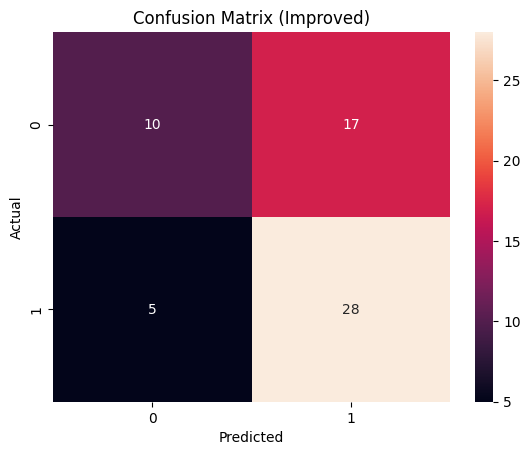


Finished: Feature Engineering, Model Selection, Bias-Variance, Cross Validation, Grid Search 


In [45]:
# 12. Confusion Matrix
cm = confusion_matrix(y_test, final_preds)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix (Improved)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 13. Completion Message
print("\nFinished: Feature Engineering, Model Selection, Bias-Variance, Cross Validation, Grid Search ")